In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import pandas as pd

# Load all three datasets
df1 = pd.read_csv('Test_Scaled_Cont_Int.csv')
df2 = pd.read_csv('Valid_Scaled_Cont_Int.csv')
df3 = pd.read_csv('Train_Scaled_Cont_Int.csv')

# Concatenate them
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

# Save the result
combined_df.to_csv('combined_dataset.csv', index=False)
X = combined_df.drop('LoanApproved', axis=1)
y = combined_df['LoanApproved']

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

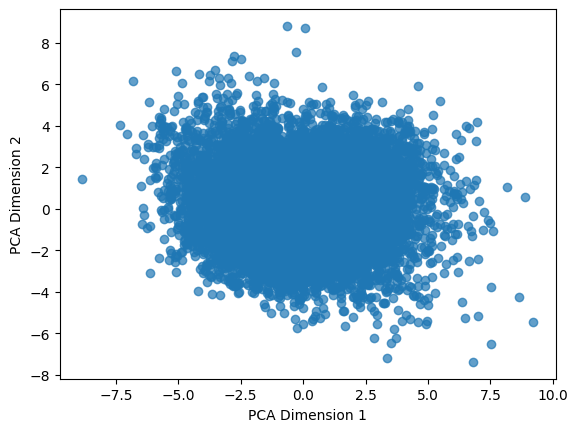

In [4]:
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.7)
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

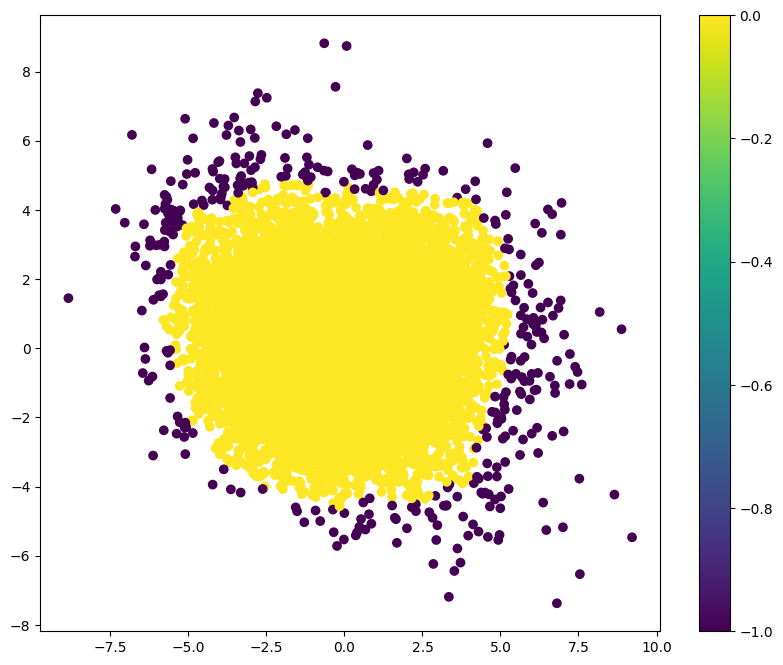

Estimated number of clusters: 1
Estimated number of noise points: 356


In [10]:
dbscan_model=DBSCAN(eps=0.5, min_samples=20).fit(X_pca)
DBSCAN_predictions = dbscan_model.labels_

n_noise_ = list(DBSCAN_predictions).count(-1)
n_clusters_ = len(set(DBSCAN_predictions)) - (1 if -1 in DBSCAN_predictions else 0)
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:,0],X_pca[:,1], c=DBSCAN_predictions)
plt.colorbar()
plt.show()
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [7]:
def purity(cluster_labels, true_labels, k):
    correct=0
    totals=0
    for cluster in range(k):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        true_digits = true_labels[cluster_indices]
        most_common = Counter(true_digits).most_common(1)[0]
        total = len(cluster_indices)
        correct+=most_common[1]
        totals+=total
        print(f"Cluster {cluster}: Most frequent digit = {most_common[0]} "
        f"({most_common[1]}/{total} = {most_common[1]/total:.2%} purity)")
    print(f"Total purity score = ({correct}/{totals} = {correct/totals:.2%} purity)")

In [12]:
purity(DBSCAN_predictions,y,1)

Cluster 0: Most frequent digit = 0 (15018/19644 = 76.45% purity)
Total purity score = (15018/19644 = 76.45% purity)


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  float64
 1   AnnualIncome                20000 non-null  float64
 2   CreditScore                 20000 non-null  float64
 3   EmploymentStatus            20000 non-null  int64  
 4   EducationLevel              20000 non-null  int64  
 5   Experience                  20000 non-null  float64
 6   LoanAmount                  20000 non-null  float64
 7   LoanDuration                20000 non-null  float64
 8   MaritalStatus               20000 non-null  int64  
 9   NumberOfDependents          20000 non-null  float64
 10  HomeOwnershipStatus         20000 non-null  int64  
 11  MonthlyDebtPayments         20000 non-null  float64
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix
import numpy as np

X = X_pca
y_true = y

def purity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

# Parameter grid
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [5, 10, 20, 30]

results = []

for min_pts in min_samples_values:
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=min_pts)
        labels = db.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        if n_clusters > 1:
            sil = silhouette_score(X, labels)
        else:
            sil = None

        purity = purity_score(y_true, labels)

        results.append({
            'eps': eps,
            'min_samples': min_pts,
            'clusters': n_clusters,
            'noise': n_noise,
            'silhouette': sil,
            'purity': purity
        })

# Print results in readable format
for r in results:
    print(f"eps={r['eps']:.2f}, min_samples={r['min_samples']}, "
          f"clusters={r['clusters']}, noise={r['noise']}, "
          f"silhouette={r['silhouette']:.3f}" if r['silhouette'] else "silhouette=N/A", 
          f", purity={r['purity']:.3f}")


eps=0.30, min_samples=5, clusters=10, noise=227, silhouette=0.186 , purity=0.763
silhouette=N/A , purity=0.761
eps=0.70, min_samples=5, clusters=2, noise=30, silhouette=0.565 , purity=0.761
silhouette=N/A , purity=0.761
eps=0.30, min_samples=10, clusters=9, noise=531, silhouette=0.046 , purity=0.762
silhouette=N/A , purity=0.761
silhouette=N/A , purity=0.761
silhouette=N/A , purity=0.761
eps=0.30, min_samples=20, clusters=3, noise=1070, silhouette=0.193 , purity=0.762
silhouette=N/A , purity=0.761
silhouette=N/A , purity=0.761
silhouette=N/A , purity=0.761
silhouette=N/A , purity=0.761
silhouette=N/A , purity=0.761
silhouette=N/A , purity=0.761
silhouette=N/A , purity=0.761


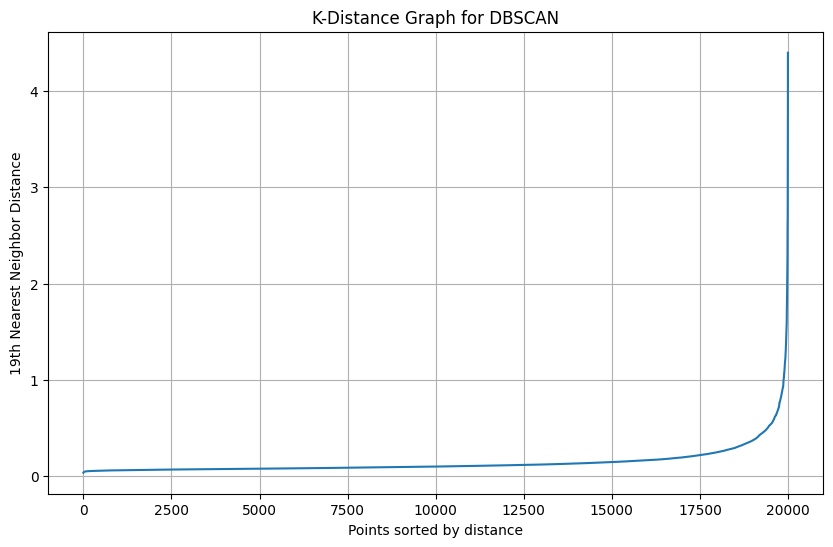

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 19  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Take the k-th nearest distances
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}th Nearest Neighbor Distance")
plt.title("K-Distance Graph for DBSCAN")
plt.grid(True)
plt.show()


In [6]:
from sklearn.metrics import silhouette_score

best_score = -1
best_eps = None

for eps in np.linspace(0.1, 2.0, 40):
    db = DBSCAN(eps=eps, min_samples=20).fit(X_pca)
    labels = db.labels_
    if len(set(labels)) > 1 and -1 not in labels:  
        score = silhouette_score(X_pca, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print(f"Best eps based on silhouette score: {best_eps}")


Best eps based on silhouette score: None
